# Check alpha constraints for bispectrum

### Import all modules

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.interpolate as interpolate
import pandas as pd
import scipy.stats

## Load data

In [3]:
Bk=np.load("z0.50/bkr_0114.npz")

In [4]:
k=Bk['k']
br=Bk['bkr']
bkrm=Bk['bkrm']

## 3D interpolation

In [5]:
dk = k[1, 2]-k[0, 2]
kmax = max(k[:, 2])
kmin = min(k[:, 2])
nk = int((kmax-kmin)/dk) + 1
kg = np.arange(kmin, kmax+dk/2, dk)
print(f'kmin={kmin:.3f}, kmax={kmax:.3f}, dk={dk:.3f}, nk={nk:d}')
br3d = np.zeros((nk, nk, nk))*np.nan
print(f'initialized 3D B(k): {br3d.shape} with k-grid = {kg}:')
for ki in range(k.shape[0]):
    i = int((k[ki, 0]-kmin)/dk)
    j = int((k[ki, 1]-kmin)/dk)
    l = int((k[ki, 2]-kmin)/dk)
    br3d[i, j, l] = bkrm[ki]
    br3d[i, l, j] = bkrm[ki]
    br3d[j, i, l] = bkrm[ki]
    br3d[j, l, i] = bkrm[ki]
    br3d[l, j, i] = bkrm[ki]
    br3d[l, i, j] = bkrm[ki]
    
ff1 = rgi((kg, kg, kg), br3d, method='linear', bounds_error=False)

kmin=0.005, kmax=0.295, dk=0.010, nk=30
initialized 3D B(k): (30, 30, 30) with k-grid = [0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105 0.115
 0.125 0.135 0.145 0.155 0.165 0.175 0.185 0.195 0.205 0.215 0.225 0.235
 0.245 0.255 0.265 0.275 0.285 0.295]:


In [6]:
br3d[:5,:5,:5]

array([[[1.26593753,        nan,        nan,        nan,        nan],
        [       nan, 1.06161787,        nan,        nan,        nan],
        [       nan,        nan, 0.99738835,        nan,        nan],
        [       nan,        nan,        nan, 1.04227411,        nan],
        [       nan,        nan,        nan,        nan, 1.05115598]],

       [[       nan, 1.06161787,        nan,        nan,        nan],
        [1.06161787, 0.90241874, 0.98087636,        nan,        nan],
        [       nan, 0.98087636, 0.98558421, 1.02391166,        nan],
        [       nan,        nan, 1.02391166, 0.98077952, 1.03024814],
        [       nan,        nan,        nan, 1.03024814, 1.00912197]],

       [[       nan,        nan, 0.99738835,        nan,        nan],
        [       nan, 0.98087636, 0.98558421, 1.02391166,        nan],
        [0.99738835, 0.98558421, 0.94301606, 1.04830533, 1.02828855],
        [       nan, 1.02391166, 1.04830533, 0.98706387, 1.06652703],
        [       

In [7]:
ff1(k)

array([       nan,        nan,        nan, ..., 1.00060598, 1.00503077,
       1.00977655])

### Check if interpolation satisfies data

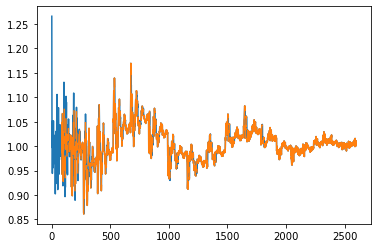

In [8]:
plt.plot(bkrm)
plt.plot(ff1(k))

### Masking at kmin=0.1,kmax=0.185

In [9]:
kmin=0.1
kmax=0.185
is_good = np.ones(k.shape[0], '?')
for i in range(3):is_good &= (k[:, i] > kmin) & (k[:, i] < kmax)
kg = k[is_good, :]
bg = bkrm[is_good]
nbins, nmocks = br[is_good, :].shape
#hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
hartlapf=1
print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}')
cov = np.cov(br[is_good, :], rowvar=True)*hartlapf / nmocks
icov = inv(cov)

kmax=0.185, kmin=0.1, nbins=120, nmocks=957


### Chisq vs alpha

In [11]:
alp=np.arange(0.90,1.10,0.01)
for alpha in alp:
    res  = bg - ff1(alpha*kg)
    chi2 = res.dot(icov.dot(res))
    print(f'{alpha:.2f} {chi2:.5f}')

0.90 16.31387
0.91 13.44526
0.92 10.88100
0.93 8.23736
0.94 6.09329
0.95 4.26707
0.96 2.75535
0.97 1.57186
0.98 0.71312
0.99 0.18355
1.00 0.00000
1.01 0.24613
1.02 1.00034
1.03 2.28161
1.04 4.09777
1.05 6.44321
1.06 9.56135
1.07 13.98610
1.08 19.26864
1.09 24.19213
1.10 29.58820


## Interpolation

#### 1. scipy.interpolate.RegularGridInterpolator

In [12]:
k1=np.unique(k[:,0])
k2=np.unique(k[:,1])
k3=np.unique(k[:,2])

kk1,kk2,kk3=np.meshgrid(k1,k2,k3)

tup_Bk=[tuple(i) for i in k[:,0:3]]

In [13]:
output = np.empty(shape=(len(k1),len(k2),len(k3)))

for i in range(len(k1)):
    for j in range(len(k2)):
        for l in range(len(k3)):
            kkk=[i for i in permutations((kk1[i,j,l],kk2[i,j,l],kk3[i,j,l]))]
            if any(set(kkk).intersection(set(tup_Bk))):
                ind=tup_Bk.index(list(set(kkk).intersection(set(tup_Bk)))[0])
                #print((kk1[i,j,k],kk2[i,j,k],kk3[i,j,k]))
                #print(Bk5[ind,0:3])
                output[i,j,l]=bkrm[ind]
            else:
                output[i,j,l]=np.nan                

In [14]:
print(output[:3,:3,:3])

[[[1.26593753        nan        nan]
  [       nan 1.06161787        nan]
  [       nan        nan 0.99738835]]

 [[       nan 1.06161787        nan]
  [1.06161787 0.90241874 0.98087636]
  [       nan 0.98087636 0.98558421]]

 [[       nan        nan 0.99738835]
  [       nan 0.98087636 0.98558421]
  [0.99738835 0.98558421 0.94301606]]]


#### Interpolating the above 3d matrix(output) in itself so that the nan values (at positions where bk doesn't exist) gets filled. This is done only for the 3d interpolation purpose. The k-values at those positions won't be considered later anyway. 

In [15]:
output_fillnan=output.flatten()
output_fillnan=pd.DataFrame(output_fillnan)
output_fillnan=output_fillnan.interpolate(method='linear', limit_direction='forward', axis=0)

In [16]:
output_fillnan=np.array(output_fillnan)
output_fillnan=np.reshape(output_fillnan,(len(k1),len(k2),len(k3)))

In [17]:
output_fillnan[:3,:3,:3]

array([[[1.26593753, 1.25934658, 1.25275562],
        [1.06820882, 1.06161787, 1.05954595],
        [1.00153219, 0.99946027, 0.99738835]],

       [[1.0288754 , 1.06161787, 1.06161787],
        [1.06161787, 0.90241874, 0.98087636],
        [0.98087636, 0.98087636, 0.98558421]],

       [[1.00270656, 1.00004745, 0.99738835],
        [0.98144574, 0.98087636, 0.98558421],
        [0.99738835, 0.98558421, 0.94301606]]])

In [18]:
ff2=rgi((k1,k2,k3),output_fillnan,method="linear",bounds_error=False,fill_value=None)
#plt.plot(ff((kg[:,0],kg[:,1],kg[:,2])))
#plt.plot(bg)

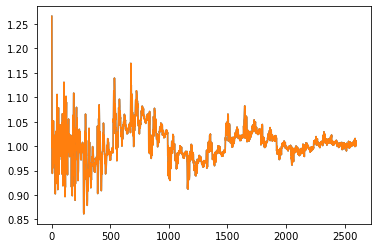

In [19]:
plt.plot(ff2((k)))
plt.plot(bkrm)

## Chi-square test

In [20]:
def chisq(obs, exp, cov):
    delta=obs-exp
    hf=1
    cov_inv=hf*inv(cov)
    return delta.dot(cov_inv.dot(delta))

In [29]:
alp=np.arange(0.90,1.10,0.01)
def chisq_alp(kg,alp,cov):
    error=[]
    obs=ff2((kg[:,0],kg[:,1],kg[:,2]))
    #obs=model.predict(Bk5[:,0:3])
    for i in alp:
        exp=ff2((kg[:,0]*i,kg[:,1]*i,kg[:,2]*i))
        print(f'{i:.2f} {chisq(obs, exp, cov):.5f}')
        #error.append(chisq(obs, exp, cov))
        #error.append(np.abs(np.array(chisq(obs, exp, cov))[0][0]))
        #ans=chisq(obs, exp,var)
        #print(i,ans)
        
    #return error

In [30]:
chisq_alp(kg,alp,cov)

0.90 16.31387
0.91 13.44526
0.92 10.88100
0.93 8.23736
0.94 6.09329
0.95 4.26707
0.96 2.75535
0.97 1.57186
0.98 0.71312
0.99 0.18355
1.00 0.00000
1.01 0.24613
1.02 1.00034
1.03 2.28161
1.04 4.09777
1.05 6.44321
1.06 9.56135
1.07 13.98610
1.08 19.26864
1.09 24.19213
1.10 29.58820
